## The purpose of the Capstone 1 project is to provide a list of recommendation to a gamer so that they may find new games that will interest them.

"Content based game recommendation" will calculate cosine similarity between reviews from multiple games to provide a list of recommended games for people who have purchased and has played games from STEAM

Cleaned game review data is imported from the pickle file

In [2]:
import pickle
file_name='cleaned_review_w_language.p'
loaded_df=pickle.load(open(file_name,"rb"))
steamapp_dict=pickle.load(open("steam.p","rb"))

In [3]:
test_id=76561198141485825

The default number of reviews obtained from the API is 20. get_reviews will retrieve review data from each game using its id and get_all_reviews will attempt to retrieve more reviews by looping over multiple iteration.

In [4]:
def get_reviews(gameid,num):
    """Takes the id number of a game and returns 20 reviews"""
    url='http://store.steampowered.com/appreviews/{}?json=1&start_offset={} '.format(gameid,num)
    r=requests.get(url)
    json_data=r.json()
    return json_data

In [5]:
import pandas as pd
def get_all_reviews(gameid):
    """Uses 'get_review' function to pull as many reviews as it can from steam website"""
    """STEAM website usually have limitation (20 reviews) on how many reviews we can pull"""
    n=0
    stop=0
    fst_iterat=get_reviews(gameid,n)
    if fst_iterat['success']==1:
        df=pd.DataFrame(fst_iterat['reviews'])
        numreview=fst_iterat['query_summary']['num_reviews']             
        while numreview==20:
            if len(df)>=120:
                break
            n+=20
            add_iterat=get_reviews(gameid,n)
            df_add=pd.DataFrame(add_iterat['reviews'])
            df=df.append(df_add)
            numreview=add_iterat['query_summary']['num_reviews']
        df_author=pd.DataFrame(df['author'].tolist())
        df['author']=df_author['steamid']
    return df[['author','recommendationid','language','review']]

Get all the application id that is on STEAM website.

In [6]:
import requests
# Get all the games that the player played
def getownedgames(idnum):
    """Takes the id number of a steam user and returns the id num of games they own"""
    url='http://api.steampowered.com/IPlayerService/GetOwnedGames/v0001/?key=3A629E52AE594CB777253431189F2967&steamid={}&format=json'.format(idnum)
    r=requests.get(url)
    json_data=r.json()
    return json_data

In [7]:
def rawplayergamelist(_id):
    """Get list of purchased game of the gamer with the _id"""
    gamelist=getownedgames(_id)['response']['games']
    return gamelist

In [8]:
testperson=rawplayergamelist(test_id)

In [9]:
testids=list()
testplaytimes=list()
for i in range(len(testperson)):
    testids.append(testperson[i]['appid'])
    testplaytimes.append(testperson[i]['playtime_forever'])

In [10]:
import pandas as pd

In [11]:
test_df=pd.DataFrame(list(zip(testids,testplaytimes)),columns=['ids','playtime']).sort_values('playtime',ascending=False)
playedgame_name=list()
for id_ in test_df['ids']:
    name=steamapp_dict.get(id_)
    playedgame_name.append(name)
test_df['name']=playedgame_name

select the games that are present in the database we set up for this analysis and make a new dataframe comprised of playtime and game ids: test_df

In [12]:
test_df.head(10)

,ids,playtime,name
27,72850,38466,The Elder Scrolls V: Skyrim
53,219740,10514,Don't Starve
15,33230,5768,Assassin's Creed II
39,317110,5524,Uncharted Waters Online: Episode Atlantis
32,242050,4405,Assassin's Creed IV Black Flag
12,22330,3391,The Elder Scrolls IV: Oblivion
17,48190,2773,Assassin's Creed Brotherhood
58,413150,2250,Stardew Valley
57,391540,1726,Undertale
31,205100,1542,Dishonored


pick most played game in the list and retreive all the reviews that are present there : player_df

default number of games is 15 but if the player played less than 15 games, it will adjust to the games that the player played for at least 30 minutes

In [13]:
if len(test_df[test_df['playtime']>=30])<15:
    topplayedgame=test_df[test_df['playtime']>=30]
else:
    topplayedgame=test_df[0:15]

In [14]:
topplayedgame=topplayedgame.set_index('ids')

In [15]:
topplayedgame.index

Int64Index([ 72850, 219740,  33230, 317110, 242050,  22330,  48190, 413150,
            391540, 205100, 311560, 208480, 368500, 201870, 261570],
           dtype='int64', name='ids')

In [16]:
steamapp_dict[313560]

'Wargame Red Dragon - The Millionth Mile'

get all reviews of the games this player enjoys: player_df

In [17]:
error=list()
for ids in topplayedgame.index:
    try:
        data=get_all_reviews(ids)
        data['game_name']=steamapp_dict.get(ids)
        if 'player_df' not in locals():
            player_df=data
        else:
            player_df=player_df.append(data, ignore_index=True, sort=False)
    except:
        error.append(ids)
        topplayedgame['name']

In [18]:
data

,author,recommendationid,language,review,game_name
0,76561198032423721,54942326,english,This game is a masterpiece. :),Ori and the Blind Forest
1,76561198331955552,54893115,english,"awesome atmosphere, story, chracterization, ga...",Ori and the Blind Forest
2,76561198350154247,55028510,english,I finished this game tonight after not playing...,Ori and the Blind Forest
3,76561198807623891,54941206,english,It one of the best game I never play and I rea...,Ori and the Blind Forest
4,76561197974484281,54832361,english,Really pretty,Ori and the Blind Forest
5,76561198252275376,54920899,english,Bruh,Ori and the Blind Forest


In [19]:
topplayedgame=topplayedgame.drop(error)

In [20]:
topplayedgame

,playtime,name
ids,,
72850,38466,The Elder Scrolls V: Skyrim
219740,10514,Don't Starve
33230,5768,Assassin's Creed II
242050,4405,Assassin's Creed IV Black Flag
22330,3391,The Elder Scrolls IV: Oblivion
48190,2773,Assassin's Creed Brotherhood
413150,2250,Stardew Valley
391540,1726,Undertale
205100,1542,Dishonored


In [21]:
player_df.head()

,author,recommendationid,language,review,game_name
0,76561198263094175,54936091,english,"As an online freelancer, it was so easy to dit...",The Elder Scrolls V: Skyrim
1,76561198198376499,54670757,english,NEVER SHOULD HAVE COME HEAR!,The Elder Scrolls V: Skyrim
2,76561198381668622,54669408,english,[b] c l o u t d i s t r i c t [b],The Elder Scrolls V: Skyrim
3,76561198354872324,55087029,english,"Currently not able to play, all I get is three...",The Elder Scrolls V: Skyrim
4,76561198149237388,55066295,english,Definitely ome of the best games in my library,The Elder Scrolls V: Skyrim


In order to use cosine similarity to compare these lists to other games, all the reviews from each games are made into one big corpus. i.e. one corpus each for all the game respectively.

In [22]:
def amalgamate(df):
    dumped_dict=dict()
    for name in df['game_name'].unique():
        dump=df.loc[(df['game_name']==name)]['review'].sum(axis=0)
        dumped_dict[name]=dump
    return dumped_dict

In [23]:
allgamedatabase=amalgamate(loaded_df)
player_dict=amalgamate(player_df)

In [24]:
player_dict.keys()

dict_keys(['The Elder Scrolls V: Skyrim', "Don't Starve", "Assassin's Creed II", "Assassin's Creed IV Black Flag", 'The Elder Scrolls IV: Oblivion ', "Assassin's Creed Brotherhood", 'Stardew Valley', 'Undertale', 'Dishonored', "Assassin's Creed Rogue", "Assassin's Creed® III", "Assassin's Creed Syndicate", "Assassin's Creed Revelations", 'Ori and the Blind Forest'])

In [25]:
for_analysis={**allgamedatabase,**player_dict}

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk.stem
import string
all_stops = stopwords.words('english')+list(string.punctuation)+['I','II','III','IV','V','VI','game','games','play']

In [27]:
import re
stemmer = nltk.stem.SnowballStemmer('english')
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

vectorizer_s = StemmedCountVectorizer(analyzer="word", stop_words=all_stops,ngram_range=(1,2),min_df=0.01,token_pattern=r'\b[^\d\W]+\b')

In [28]:
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedTfidfVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

tfidf_s = StemmedTfidfVectorizer(smooth_idf=False, sublinear_tf=False, norm=None, analyzer='word', stop_words=all_stops,ngram_range=(1,2),min_df=0.01,token_pattern=r'\b[^\d\W]+\b')

In [29]:
text=player_df.review.sum(axis=0)

In [32]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

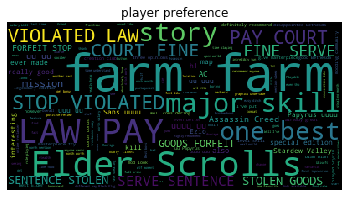

In [33]:
wordcloud=WordCloud(stopwords=all_stops).generate(text)
plt.axis('off')
plt.title('player preference')
plt.imshow(wordcloud)

From all the games this player played, the term "story" pops up quite a lot giving us a clue that this player enjoys games that has story element to it. They may like a game that has a lot of characters.

"time" also shows up quite a lot but it is unsure just from this wordcloud whether that means a game that takes a lot of time to play or the opposite.




<br>
Using only the stems of each words, I calculate the TF-IDF scores of the reviews

In [34]:
def stemvect(text):
    X=vectorizer_s.fit_transform(text)
    return X.toarray(), vectorizer_s.get_feature_names()

In [35]:
def stemtfidf(text):
    X=tfidf_s.fit_transform(text)
    return X.toarray(),tfidf_s.get_feature_names()

In [36]:
freq,words=stemvect(for_analysis.values())
tdfscore,tdfwords=stemtfidf(for_analysis.values())

/home/seo/environments/my_env/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ii', 'iii', 'iv', 'v', 'vi'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/home/seo/environments/my_env/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ii', 'iii', 'iv', 'v', 'vi'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [37]:
games_tdf=pd.DataFrame(tdfscore,index=for_analysis.keys(),columns=tdfwords)

In [38]:
games_tdf.head()

,aaa,abandon,abil,abl,able get,absolut,absolutely lov,absurd,accept,access,...,yet,young,younger,youtu,youtub,youtube com,zero,zombi,zone,zoom
Pikuniku Soundtrack + Comic,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Four-color Fantasy,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Drag Star!,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,4.567581,0.0,0.0
Hentai balls v3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Age Of Omens,0.0,0.0,0.0,2.883627,0.0,0.0,0.0,0.0,0.0,6.527426,...,5.658475,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


These will in turn be used to calculate cosine similarity with each other: matrixforgame

This allows us to find out how similar each game's reviews are to others, which in turn implies how similar each game is to the other

In [ ]:
list_of_games=games_tdf.index.tolist()
listlength=len(list_of_games)
import numpy as np
from scipy import spatial
matrixforgame=np.zeros(shape=(listlength,listlength))
for i in range(len(list_of_games)):
    game=list_of_games[i]
    for j in range(len(list_of_games)):
        another=list_of_games[j]
        if game!=another:
            result=1-spatial.distance.cosine(games_tdf.loc[game].values,games_tdf.loc[another].values)
            matrixforgame[i][j]=result

/home/seo/environments/my_env/lib/python3.6/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [ ]:
result_df=pd.DataFrame(matrixforgame,index=list_of_games,columns=list_of_games)

In [ ]:
import seaborn as sns
sns.heatmap(result_df[topplayedgame['name']])

You can see as a heat map that there were a lot more games similar to Undertale than Assassins's Creed Brotherhood.<br>
There also seem to be a small number of game that was very similar to Ori and the Blind Forest as there is one bright band.


<br>
<br>

I added weight to each games according to how long the player played it for and added all the cosine similarity values: result_df<br>
This allows me to get a list of games that this player is likely to enjoy because they played these list of games a lot.

In [ ]:
weight=len(list(player_dict.keys()))
result_df['total'] = 0
for name in player_df['game_name'].unique():
    result_df['total']=result_df['total']+(weight*result_df[name])
    weight=weight-1

remove the games that this player already possess: removed<br>
Then we take the top 10 games with the largest similarity: finaltop10recommendation

In [ ]:
alreadyownedgames=test_df['name'].tolist()
removed=[name for name in result_df.index.tolist() if name not in alreadyownedgames]

In [ ]:
finaltop10recommendation=result_df['total'].loc[removed].sort_values(ascending=False)[0:10]
final_list=finaltop10recommendation.index.tolist()

To give users accessibility, I added in urls to each recommended game and presented them: recommended_games

In [ ]:
recommended_games=list()
for name in final_list:
    ids=list(steamapp_dict.keys())[list(steamapp_dict.values()).index(name)]
    recommended_games.append((name,"https://store.steampowered.com/app/"+str(ids)))

In [ ]:
plot_num=1
plt.figure(figsize = (50,30))
for name in final_list:
    working_data=review_df[review_df['game_name']==name]
    text=working_data.review.sum(axis=0)
    wordcloud=WordCloud(stopwords=all_stops).generate(text)
    plt.subplot(2, 5, plot_num)
    plt.gca().set_title(name, fontsize=30)
    plt.imshow(wordcloud,aspect='auto')
    plt.axis('off')
    plot_num=plot_num+1

In [ ]:
print("\nBecause you played games such as {}, {} and {}, \n you will like these games as well!\n".format(alreadyownedgames[0],alreadyownedgames[1],alreadyownedgames[2]))
print(pd.DataFrame(recommended_games,columns=["Game Name","Store page"]))